# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [23]:
from typing import Callable, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities


In [24]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(possible_params_dict: dict[str, list]):
    if len(possible_params_dict) == 0:
        return [{}]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            {first_item[0]: first_item[1], **k}
            for k in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    return [
        {first_item[0]: x, **k}
        for k in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [25]:
def rmse_score(
    initial_matrix: torch.tensor, predicted_matrix: torch.tensor, test_mask: torch.tensor
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return torch.sqrt(differences.mean()).item()

In [26]:
def choose_best(
    matrix: torch.tensor,
    mask: torch.tensor,
    test_mask: torch.tensor,
    solver: Callable,
    possible_params: dict,
    loss_param: str = "rmse",
) -> tuple[torch.tensor, float, dict, dict]:
    best_loss = 1e3
    best_solution = np.zeros(1)
    best_params = {}

    log_dicts = {}

    for params in get_params_combinations_dict(possible_params):
        solution, log_dict = solver(matrix, mask, test_mask, **params)
        log_dicts[str(params)] = log_dict

        loss = log_dict[loss_param][-1]

        if loss < best_loss:
            best_loss = loss
            best_solution = solution.clone()
            best_params = params.copy()

    return best_solution, best_loss, best_params, log_dicts

In [27]:
def plot_log_dicts(log_dicts: dict, title: str):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(5 * 2, 7 * 1),
    )
    axs_list = list(axs.flat)

    for ax in axs_list:
        ax.grid()

    axs[0].set(xlabel="Iteration", ylabel="Objective, log")
    axs[1].set(xlabel="Iteration", ylabel="RMSE, log")
    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    for idx, (name, log_dict) in enumerate(log_dicts.items()):
        axs[0].plot(log_dict["iteration"], log_dict["objective"], label=f"{idx}")
        axs[0].plot(log_dict["iteration"], log_dict["objective_test"], label=f"{idx}_test")
        axs[1].plot(log_dict["iteration"], log_dict["rmse"], label=f"{idx}")
        axs[1].plot(log_dict["iteration"], log_dict["rmse_test"], label=f"{idx}_test")

    fig.suptitle(title, fontsize=14)

    lines_labels = [axs_list[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    fig.legend(
        lines,
        labels,
        loc="outside lower center",
        bbox_to_anchor=(0.5, -0.05),
    )
    plt.tight_layout()
    plt.show()

In [28]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return torch.tensor(train_matrix.reshape(matrix_shape)).float().to(DEVICE), torch.tensor(train_mask.reshape(matrix_shape)).bool().to(DEVICE), torch.tensor(test_mask.reshape(matrix_shape)).bool().to(DEVICE), torch.tensor(matrix).float().to(DEVICE), torch.tensor(mask).bool().to(DEVICE)

## Data loading


### Toy data


In [29]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)

toy_mask_full = toy_matrix_full != 0

In [30]:
toy_matrix, toy_mask, toy_test_mask, toy_matrix_full, toy_mask_full = train_test_split_matrix(
    toy_matrix_full, toy_mask_full, test_percent=0.2
)

In [31]:
toy_matrix

tensor([[2., 3., 2., 0., 0.],
        [0., 2., 0., 4., 0.],
        [3., 0., 3., 0., 4.],
        [0., 3., 0., 4., 0.],
        [0., 0., 0., 0., 2.],
        [1., 0., 3., 4., 0.]], device='cuda:0')

In [32]:
toy_matrix[1, :]

tensor([0., 2., 0., 4., 0.], device='cuda:0')

In [33]:
torch.dot(toy_matrix[1, :], toy_matrix[1, :])

tensor(20., device='cuda:0')

In [34]:
toy_matrix.shape[0]

6

### Real data


In [35]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask

In [36]:
# def load_real_data() -> tuple[torch.tensor, torch.tensor]:
#     data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
#     x = csr_matrix(data["X"]).toarray()
#     mask = x != 0
#     return torch.tensor(x).float().to(DEVICE), torch.tensor(mask).to(DEVICE)


real_matrix_full, real_mask_full = load_real_data()

In [37]:
real_matrix, real_mask, real_test_mask, real_matrix_full, real_mask_full = train_test_split_matrix(
    real_matrix_full, real_mask_full, test_percent=0.2
)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 160033


## Test real data


In [38]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> torch.tensor:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0].astype(np.float64) - 1
    columns_indices = x[:, 1].astype(np.float64) - 1
    return (
        torch.tensor(rows_indices * real_matrix_shape[1] + columns_indices)
        .int()
        .to(DEVICE)
    )


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

tensor([     593,     3104,     1544,  ..., 23868889, 23868137, 23868149],
       device='cuda:0', dtype=torch.int32)

In [39]:
def save_solution(
    matrix: torch.tensor,
    test_flatten_indices: torch.tensor = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(
        matrix.flatten()[test_flatten_indices].cpu().numpy(), decimals=decimals
    )
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Block coordinate descent


In [40]:
class Optimizer:
    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        raise NotImplementedError

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        return -grad

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, *args
    ) -> torch.tensor:
        return x - lr * grad


class Nesterov(Optimizer):
    def __init__(self, beta: float = 0.99):
        self.beta = beta

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        h = grad.clone() if k == 0 else self.beta * self.h_prev + grad
        return -(grad + self.beta * h)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        if k == 0:
            self.h = grad.clone()
        else:
            self.h = self.beta * self.h_prev + grad
        g = grad + self.beta * self.h
        self.h_prev = self.h.clone()
        return x - lr * g


class AdaGrad(Optimizer):
    def __init__(
        self,
        eps=1e-10,
        lr_decay: float = 0,
    ):
        self.lr_decay = lr_decay
        self.eps = eps
        self.state_sum = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        if self.state_sum is None:
            state_sum = torch.zeros_like(grad)
        else:
            state_sum = self.state_sum.clone()
        state_sum += grad**2

        return -grad / torch.sqrt(state_sum + self.eps)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        gamma = lr / (1 + k * self.lr_decay)
        if self.state_sum is None:
            self.state_sum = torch.zeros_like(grad)

        self.state_sum += grad**2

        return x - gamma * grad / torch.sqrt(self.state_sum + self.eps)


class RMSprop(Optimizer):
    def __init__(
        self,
        eps=1e-10,
        alpha=0.99,
    ):
        self.alpha = alpha
        self.eps = eps

        self.exp_avg_sq = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        if self.exp_avg_sq is None:
            exp_avg_sq = torch.zeros_like(x)
        else:
            exp_avg_sq = self.exp_avg_sq.copy()

        exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        return -grad / torch.sqrt(exp_avg_sq + self.eps)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        if self.exp_avg_sq is None:
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        return x - lr * grad / torch.sqrt(self.exp_avg_sq + self.eps)


class Adam(Optimizer):
    def __init__(
        self,
        betas: tuple[float, float] = (0.9, 0.999),
        eps=1e-10,
        weight_decay: float = 1e-2,
    ):
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.exp_avg = None
        self.exp_avg_sq = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        step_k = k + 1
        beta1, beta2 = self.betas

        exp_avg = (
            self.exp_avg.clone() if self.exp_avg is not None else torch.zeros_like(x)
        )
        exp_avg_sq = (
            self.exp_avg_sq.clone()
            if self.exp_avg_sq is not None
            else torch.zeros_like(x)
        )

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**step_k
        bias_correction2 = 1 - beta2**step_k

        denom = exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        return -torch.div(exp_avg, bias_correction1).div_(denom) - self.weight_decay * x

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        step_k = k + 1

        beta1, beta2 = self.betas
        if self.exp_avg is None or self.exp_avg_sq is None:
            self.exp_avg = torch.zeros_like(x)
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        self.exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**step_k
        bias_correction2 = 1 - beta2**step_k

        denom = self.exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        return (
            x
            - lr * torch.div(self.exp_avg, bias_correction1).div_(denom)
            - lr * self.weight_decay * x
        )

In [41]:
def estimate_1overL(
    x: torch.tensor,
    grad: torch.tensor,
    f,
    direction: torch.tensor,
    beta: float = 0.25,
    iters: int = 100,
    eps: float = 1e-7,
):
    alpha = 1

    i = 0
    while True:
        x_next = x + alpha * direction
        if f(x_next) > eps + f(x) + torch.trace(grad.T @ (x_next - x)) + torch.norm(
            x_next - x, p="fro"
        ) ** 2 / (2 * alpha):
            i += 1
            alpha *= beta
            if alpha < 1e-10:
                return alpha

        else:
            return alpha

        if i >= iters:
            return alpha


def adaptive_step(
    x: torch.tensor,
    prev_x: torch.tensor,
    grad: torch.tensor,
    prev_grad: torch.tensor,
    prev_step,
    theta,
    start_step: float = 1e-10,
):
    if prev_step is None:
        step = start_step
        theta = np.inf
        return step, theta

    step = prev_step
    if torch.norm(prev_grad - grad) < 1e-5:
        min_value = np.sqrt(1 + theta) * step
    else:
        min_value = min(
            np.sqrt(1 + theta) * step,
            torch.norm(x - prev_x).cpu().numpy()
            / (2 * torch.norm(prev_grad - grad).cpu().numpy()),
        )

    if min_value == np.inf:
        min_value = 0.001

    theta = min_value / step
    step = min_value
    return step, theta


def armijo(
    x,
    grad,
    f,
    direction: torch.tensor,
    c1: float = 1e-6,
    beta: float = 0.5,
    iters: int = 50,
    alpha_init: float = 1,
):
    alpha = alpha_init

    d_g = torch.trace(grad.T @ direction).item()
    f_x = f(x)

    # print((f(x + alpha * direction) - f_x) / (alpha * d_g))

    i = 0
    while f(x + alpha * direction) > f_x + c1 * alpha * d_g:
        i += 1

        if i == iters:
            return alpha

        if alpha < 1e-7:
            return alpha

        alpha = alpha * beta

    return alpha


def bisection_weak_wolfe(
    x,
    grad,
    grad_f,
    f,
    direction: torch.tensor,
    c1: float = 1e-5,
    c2: float = 0.9,
    alpha_init: float = 1.0,
    iters: int = 100,
):
    alpha = alpha_init
    lb = 0
    ub = np.inf

    d_g = torch.trace(grad.T @ direction)

    i = 0
    while True:
        i += 1
        if f(x + alpha * direction) > f(x) + c1 * alpha * d_g:
            ub = alpha
            alpha = 0.5 * (lb + ub)
        elif torch.trace(grad_f(x + alpha * direction).T @ direction) < c2 * d_g:
            lb = alpha
            alpha = 2 * lb if np.isinf(ub) else 0.5 * (lb + ub)
        else:
            break
        if alpha < 1e-16:
            return alpha
        if i > iters:
            break
    return alpha

In [146]:
def pred(u: torch.tensor, v: torch.tensor) -> torch.tensor:
    return torch.clip(u @ v, 1, 5)


def init_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    rank: int,
    strategy: Literal["random", "svd", "mean"],
) -> tuple[torch.tensor, torch.tensor]:
    m, n = matrix.shape
    new_matrix = matrix.cpu().numpy()

    if strategy == "random":
        return torch.rand(m, rank).to(DEVICE), torch.rand(rank, n).to(DEVICE)

    if strategy == "mean":
        new_matrix = SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(
        new_matrix, n_iter=25, n_components=rank
    )
    v = vt

    return torch.tensor(u).float().to(DEVICE), torch.tensor(v).float().to(DEVICE)


def objective_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    u: torch.tensor,
    v: torch.tensor,
    regularization: float = 0.0,
) -> float:
    return (
        torch.norm(mask * torch.pow((matrix - (u @ v)), 2), p="fro")
        + regularization * (torch.norm(u, p="fro") ** 2 + torch.norm(v, p="fro") ** 2)
    ).item()


def nabla_objective_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    u: torch.tensor,
    v: torch.tensor,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.tensor:
    if for_v:
        return (
            -2 * u.T @ (mask * matrix)
            + 2 * u.T @ (mask * (u @ v))
            + regularization * 2 * v
        )

    return (
        -2 * (mask * matrix) @ v.T + 2 * (mask * (u @ v)) @ v.T + regularization * 2 * u
    )

def block_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    test_mask: torch.tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            if lr_strategy == "adaptive":
                # Adaptive step
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                stepu, thetau = adaptive_step(
                    u, prev_u, grad_u, prev_grad_u, stepu, thetau, start_step=lr_func(0)
                )
                prev_grad_u = grad_u.clone()

                prev_u = u.clone()
                u = u_optim.step(
                    u,
                    grad_u,
                    stepu,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                stepv, thetav = adaptive_step(
                    v, prev_v, grad_v, prev_grad_v, stepv, thetav, start_step=lr_func(0)
                )
                prev_grad_v = grad_v.clone()

                prev_v = v.clone()
                v = v_optim.step(
                    v,
                    grad_v,
                    stepv,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )
            elif lr_strategy == "normal":
                # Ordinary
                alpha_u = alpha_v = lr_func(k)
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            elif lr_strategy == "armijo_rule":
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = armijo(
                    u,
                    grad_u,
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = armijo(
                    v,
                    grad_v,
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            elif lr_strategy == "1/L":
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = estimate_1overL(
                    u,
                    grad_u,
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = estimate_1overL(
                    v,
                    grad_v,
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )
            else:
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = bisection_weak_wolfe(
                    u,
                    grad_u,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                    # alpha_init=lr_func(k) if k == 0 else alpha_u * 1.5,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = bisection_weak_wolfe(
                    v,
                    grad_v,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                    # alpha_init=lr_func(k) if k == 0 else alpha_v * 1.5,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(matrix, test_mask, u, v, regularization=regularization)

            rmse_sc = rmse_score(matrix, pred(u, v), mask)
            rmse_sc_test = rmse_score(matrix, pred(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix({"Objective": objective, "RMSE": rmse_sc})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * pred(u, v), log_dict

def nabla_objective_gd_cords(
    matrix: torch.tensor,
    mask: torch.tensor,
    u: torch.tensor,
    v: torch.tensor,
    i: int,
    j: int,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.tensor:
    if for_v:
        return (
            -(matrix[i, j] - torch.dot(u[i, :], v[:, j])) * u[i, :] - regularization * v[:, j]
        )

    return (
        -(matrix[i, j] - torch.dot(u[i, :], v[:, j])) * v[:, j] - regularization * u[i, :]
    )    

def coordinate_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    test_mask: torch.tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()
    print(matrix.shape)
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            # Naive approach
            # Update only U
            for i in range(matrix.shape[0]):
                indices = torch.where(mask[i, :] > 0)[0]
                for j_tens in indices:
                    j = j_tens.item()
                    if lr_strategy == "adaptive":
                        # Adaptive step
                        grad_u = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, regularization=regularization
                        )
                        stepu, thetau = adaptive_step(
                            u, prev_u, grad_u, prev_grad_u, stepu, thetau, start_step=lr_func(0)
                        )
                        prev_grad_u = grad_u.clone()

                        prev_u = u.clone()
                        u[i, :] = u_optim.step(
                            u[i, :],
                            grad_u,
                            stepu,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, x, v, i, j, regularization=regularization
                            ),
                        )
                    elif lr_strategy == "normal":
                        # Ordinary
                        alpha_u = alpha_v = lr_func(k)
                        grad_u = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, regularization=regularization
                        )
                        u[i, :] = u_optim.step(
                            u[i, :],
                            grad_u,
                            alpha_u,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, x, v, i, j, regularization=regularization
                            ),
                        )
            
                    # err_ij = matrix[i, j] - torch.dot(u[i, :], v[:, j])
                    # u[i, :] += lr * (err_ij * v[:, j] - regularization * u[i, :])
            
            for j in range(matrix.shape[1]):
                indices = torch.where(mask[:, j] > 0)[0]
                for i_tens in indices:
                    i = i_tens.item()
                    if lr_strategy == "adaptive":
                        grad_v = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, for_v=True, regularization=regularization
                        )
                        stepv, thetav = adaptive_step(
                            v, prev_v, grad_v, prev_grad_v, stepv, thetav, start_step=lr_func(0)
                        )
                        prev_grad_v = grad_v.clone()

                        prev_v = v.clone()
                        v[:, j] = v_optim.step(
                            v[:, j],
                            grad_v,
                            stepv,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, u, x, i, j, for_v=True, regularization=regularization
                            ),
                        )
                    elif lr_strategy == "normal":
                        grad_v = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, for_v=True, regularization=regularization
                        )
                        v[:, j] = v_optim.step(
                            v[:, j],
                            grad_v,
                            alpha_v,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, u, x, i, j, for_v=True, regularization=regularization
                            ),
                        )
                    
                    # err_ij = matrix[i, j] - torch.dot(u[i, :], v[:, j])
                    # v[:, j] += lr * (err_ij * u[i, :] - regularization * v[:, j]) 

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(matrix, test_mask, u, v, regularization=regularization)

            rmse_sc = rmse_score(matrix, pred(u, v), mask)
            rmse_sc_test = rmse_score(matrix, pred(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix({"Objective": objective, "RMSE": rmse_sc})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * pred(u, v), log_dict
    

def nnmf_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    test_mask: torch.tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)
    u = torch.clip(u, 0)
    v = torch.clip(v, 0)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()

    eps = 1e-10
    F = u @ torch.ones(rank).float().to(DEVICE)
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            # Naive approach
            # Update only U

            A = matrix @ v.T
            B = v @ v.T

            for j in range(rank):
                uj = F - u[:,j]
                h = A[:, j] - u @ B[:, j] + B[j, j] * u[:, j]
                u[:, j] = torch.max(torch.zeros(len(h)).float().to(DEVICE) + eps, h - (uj @ h) / (uj @ uj) * uj)
                u[:, j] = u[:, j] / torch.pow((u[:, j] @ u[:, j]), 1/2) # мб взять корень для нормализации
                F = uj + u[:, j]
            
            C = matrix.T @ u
            D = u.T @ u

            for j in range(rank):
                v[j, :] = torch.max(torch.zeros(len(v[j, :])).float().to(DEVICE) + eps, C[:, j] - v.T @ D[:, j] + D[j,j] * v[j, :])

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(matrix, test_mask, u, v, regularization=regularization)

            rmse_sc = rmse_score(matrix, pred(u, v), mask)
            rmse_sc_test = rmse_score(matrix, pred(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix({"Objective": objective, "RMSE": rmse_sc, "RMSE Test": rmse_sc_test})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * pred(u, v), log_dict

In [147]:
toy_matrix

tensor([[2., 3., 2., 0., 0.],
        [0., 2., 0., 4., 0.],
        [3., 0., 3., 0., 4.],
        [0., 3., 0., 4., 0.],
        [0., 0., 0., 0., 2.],
        [1., 0., 3., 4., 0.]], device='cuda:0')

In [148]:
toy_matrix[:, 1] @ toy_matrix[:, 1]

tensor(22., device='cuda:0')

100%|██████████| 10/10 [00:00<00:00, 115.40it/s, Objective=6.5, RMSE=0.856]


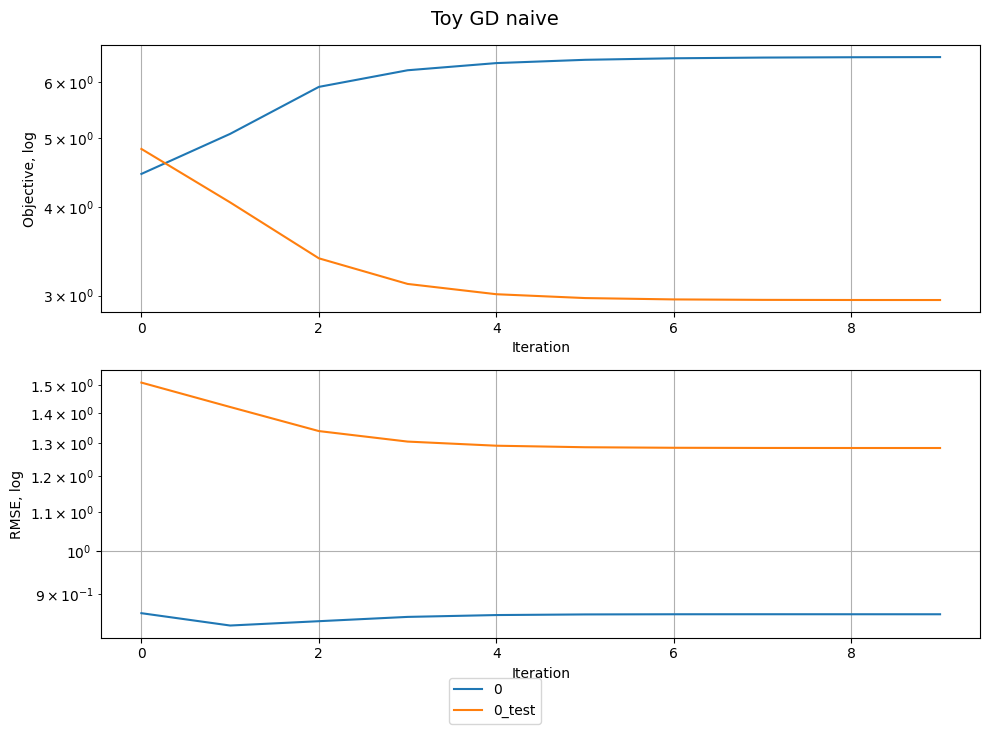

(tensor([[2.0000, 3.0000, 2.0000, 1.0000, 1.3776],
         [1.0000, 2.0000, 1.0000, 4.0000, 1.0000],
         [3.0000, 1.0000, 3.0000, 1.0000, 4.0000],
         [1.0000, 3.0000, 1.0000, 4.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 2.0000],
         [1.0000, 1.7194, 3.0000, 4.0000, 1.0000]], device='cuda:0'),
 0.855913519859314,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.001,
  'optimizer': __main__.GradientDescent,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'normal'})

In [138]:
gd_toy_res_nnmf = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    nnmf_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-3,
        "optimizer": GradientDescent,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_toy_res_nnmf[-1], "Toy GD naive")

gd_toy_res_nnmf[:-1]

100%|██████████| 10/10 [00:00<00:00, 25.05it/s, Objective=7.21e+3, RMSE=2.34, RMSE Test=1.33]


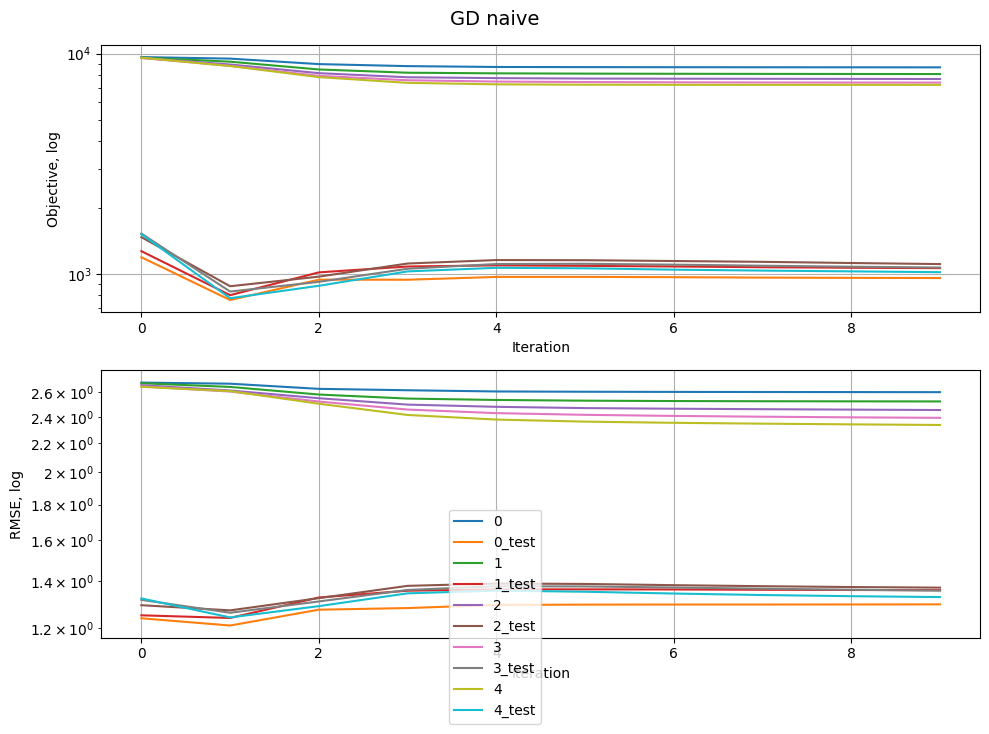

(tensor([[5., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'),
 2.3369967937469482,
 {'rank': 100,
  'iterations': 10,
  'init_strategy': 'random',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 0.001,
  'lr_strategy': 'normal'})

In [150]:
gd_res_nnmf = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    nnmf_gd,
    {
        "rank": [10, 25, 50, 75, 100],
        "iterations": 10,
        "init_strategy": "random",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization":  0,
        "clip": False,
        "lr": 1e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_res_nnmf[-1], "GD naive")

gd_res_nnmf[:-1]

100%|██████████| 10/10 [00:00<00:00, 23.52it/s, Objective=7.29e+3, RMSE=2.33, RMSE Test=1.29]


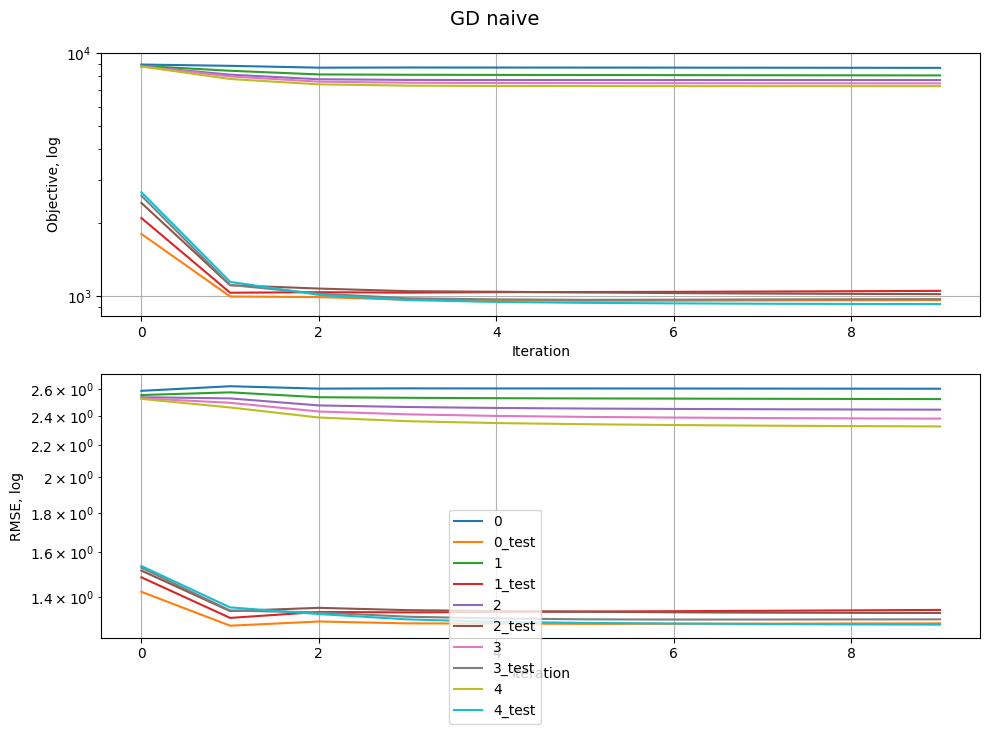

(tensor([[5.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.2508, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [3.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 2.326040029525757,
 {'rank': 100,
  'iterations': 10,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 0.001,
  'lr_strategy': 'normal'})

In [151]:
gd_res_nnmf = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    nnmf_gd,
    {
        "rank": [10, 25, 50, 75, 100],
        "iterations": 10,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization":  0,
        "clip": False,
        "lr": 1e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_res_nnmf[-1], "GD naive")

gd_res_nnmf[:-1]

100%|██████████| 10/10 [00:00<00:00, 59.72it/s, Objective=0.198, RMSE=0.155]


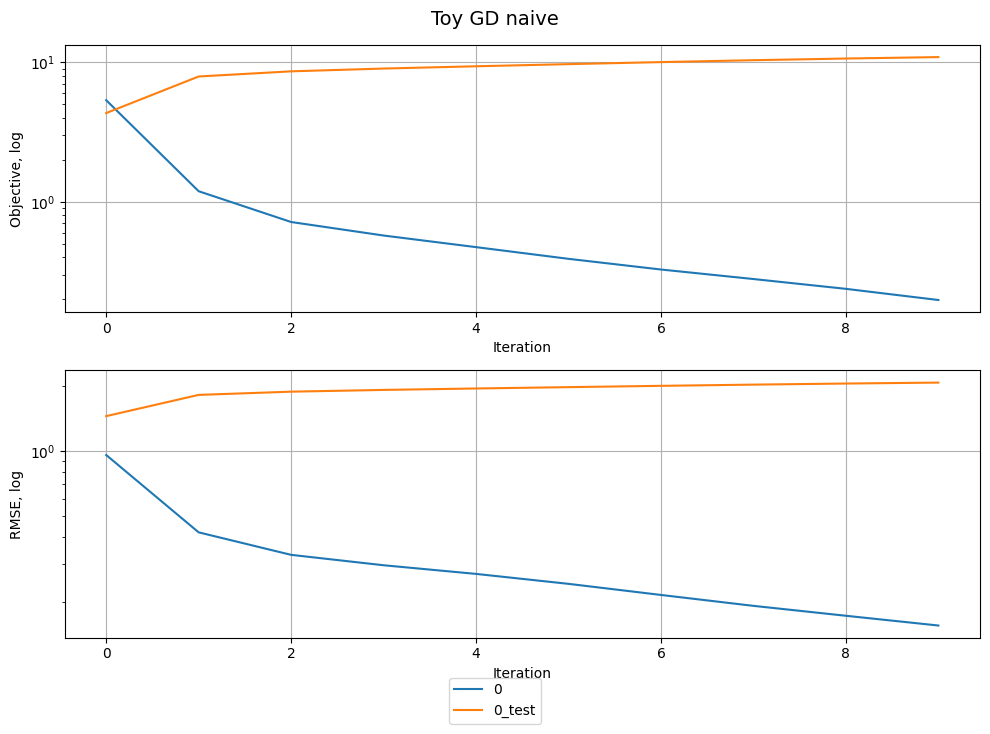

(tensor([[2.0000, 3.0000, 2.0000, 1.5241, 2.0956],
         [1.0000, 2.0000, 1.8913, 4.0000, 1.0000],
         [3.0000, 3.7639, 3.0000, 1.0000, 4.0000],
         [1.0000, 3.0000, 2.7349, 4.0000, 1.0000],
         [1.5018, 2.2357, 1.8548, 1.0000, 2.0000],
         [1.0000, 3.3003, 3.0000, 4.0000, 1.2152]], device='cuda:0'),
 0.1551935374736786,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.RMSprop,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'normal'})

In [ ]:
gd_toy_res_cord = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    coordinate_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-1,
        "optimizer": RMSprop,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_toy_res_cord[-1], "Toy GD naive")

gd_toy_res_cord[:-1]

torch.Size([6040, 3952])


100%|██████████| 10/10 [55:26<00:00, 332.61s/it, Objective=nan, RMSE=nan]    


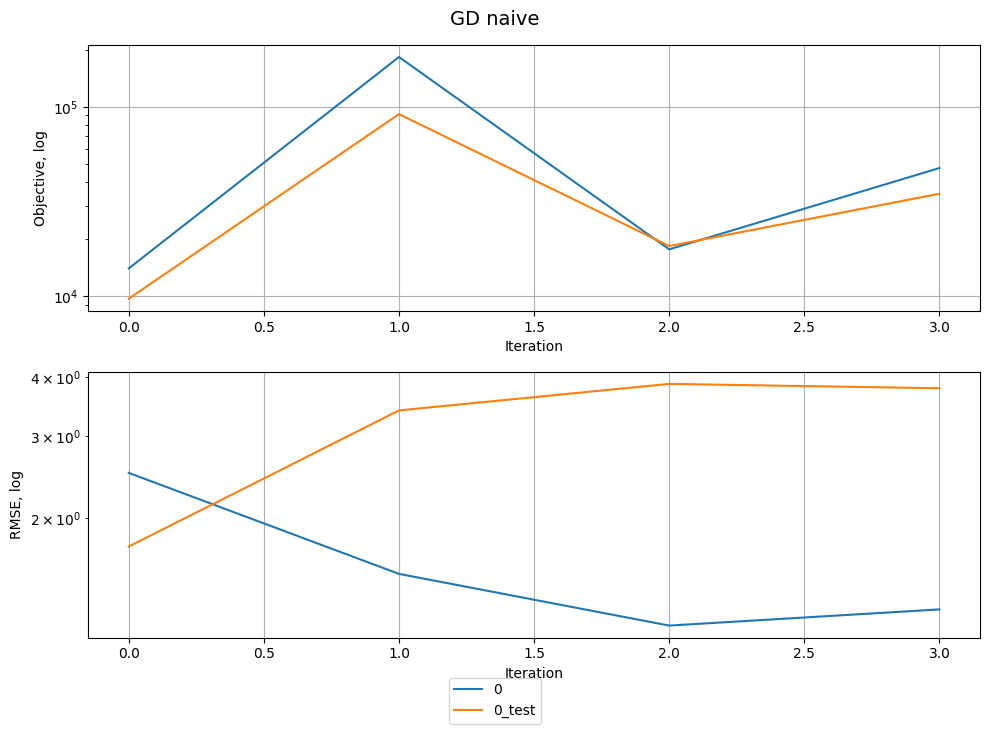

(array([0.]), 1000.0, {})

In [225]:
gd_res_cord = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    coordinate_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization":  1e-1,
        "clip": False,
        "lr": 1e-2,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_res_cord[-1], "GD naive")

gd_res_cord[:-1]

100%|██████████| 10/10 [00:00<00:00, 86.50it/s, Objective=0.149, RMSE=0.153]


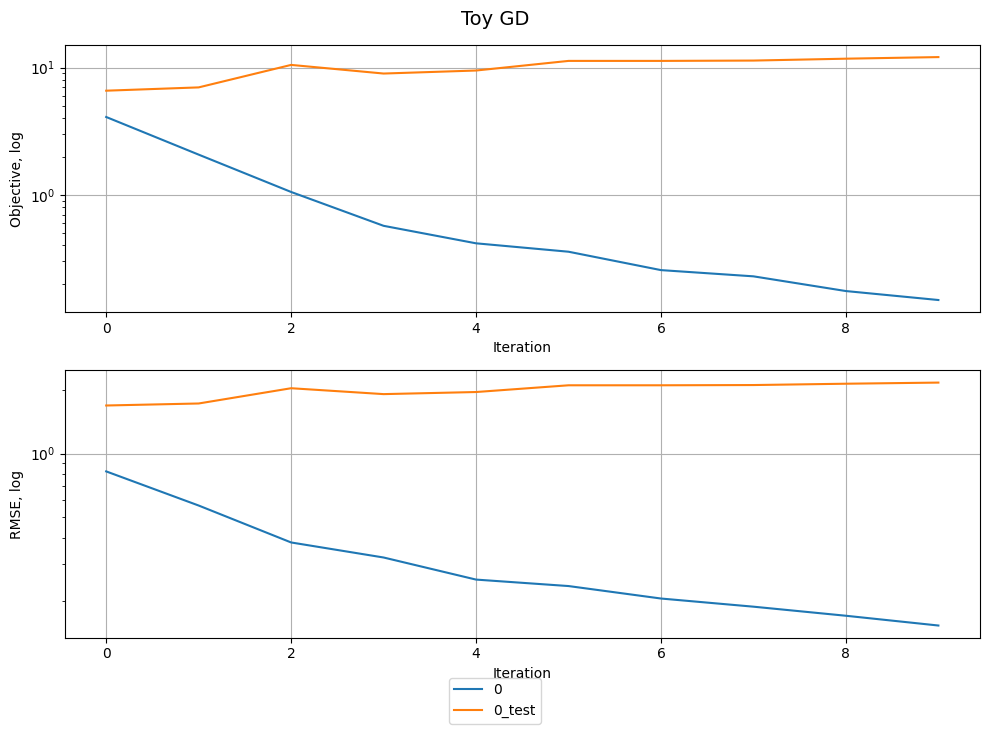

(tensor([[2.0000, 3.0000, 2.0000, 2.7468, 2.8031],
         [1.0000, 2.0000, 2.1565, 4.0000, 1.0000],
         [3.0000, 3.8533, 3.0000, 3.4516, 4.0000],
         [1.0000, 3.0000, 2.5099, 4.0000, 1.0000],
         [1.8218, 1.3039, 1.0000, 1.0000, 2.0000],
         [1.0000, 3.4770, 3.0000, 4.0000, 2.3063]], device='cuda:0'),
 0.15337860584259033,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.GradientDescent,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'bisection'})

In [118]:
gd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    block_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-1,
        "optimizer": GradientDescent,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy GD")

gd_toy_res[:-1]

100%|██████████| 100/100 [00:14<00:00,  6.84it/s, Objective=913, RMSE=0.783]   


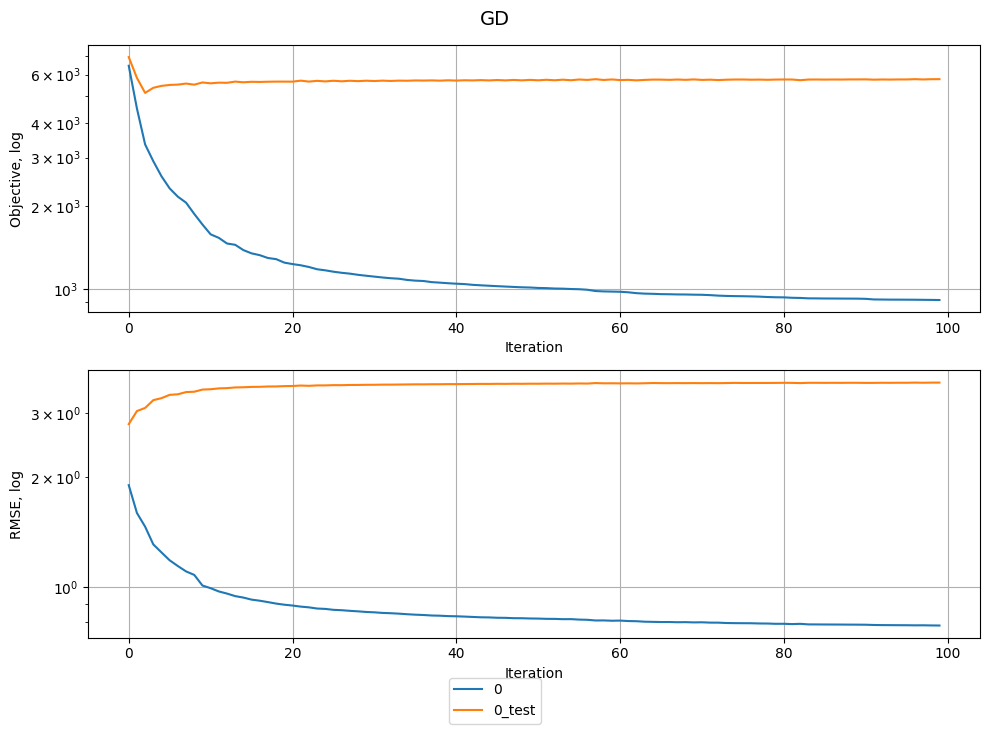

(tensor([[5.0000, 3.3997, 3.2944,  ..., 2.9080, 2.8253, 3.3777],
         [3.8702, 2.9555, 3.1424,  ..., 3.2914, 3.0654, 3.9299],
         [3.7768, 3.2901, 3.5227,  ..., 3.0482, 2.5501, 3.9151],
         ...,
         [3.6132, 2.5510, 2.5101,  ..., 2.8648, 2.9242, 3.5902],
         [3.6859, 2.6066, 2.1818,  ..., 3.0362, 3.2458, 3.2782],
         [3.0000, 1.4490, 1.0000,  ..., 3.5622, 4.5139, 3.4821]],
        device='cuda:0'),
 0.783055305480957,
 {'rank': 10,
  'iterations': 100,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 0.01,
  'lr_strategy': 'bisection'})

In [135]:
gd_bis_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 100,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-2,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_bis_res[-1], "GD")

gd_bis_res[:-1]

100%|██████████| 500/500 [00:06<00:00, 81.34it/s, Objective=896, RMSE=0.773]   


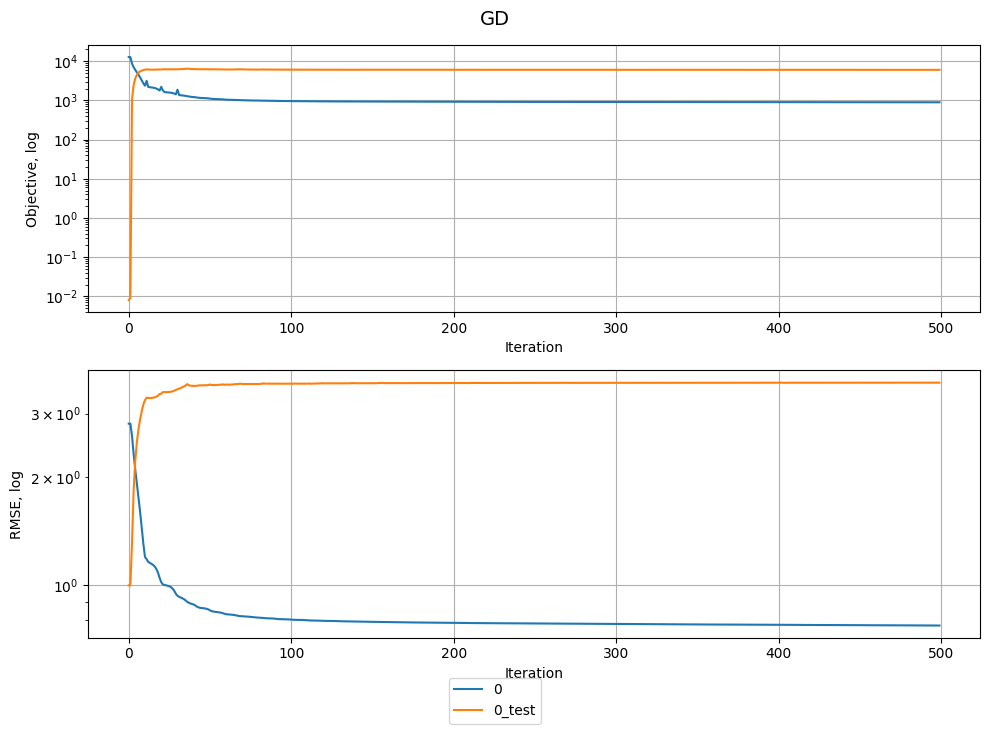

(tensor([[5.0000, 3.6355, 3.5984,  ..., 3.9750, 4.1839, 3.7113],
         [4.5044, 3.3758, 3.3407,  ..., 3.7192, 3.9229, 3.8037],
         [3.5508, 3.5909, 3.6401,  ..., 3.0027, 3.0546, 3.3285],
         ...,
         [5.0000, 1.0000, 1.0000,  ..., 3.0825, 3.9006, 4.0787],
         [3.6469, 3.2007, 2.9571,  ..., 3.5705, 3.8981, 3.7457],
         [3.0000, 1.5077, 1.1421,  ..., 3.6881, 4.2617, 3.7305]],
        device='cuda:0'),
 0.7732722163200378,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 1e-10,
  'lr_strategy': 'adaptive'})

In [137]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-10,
        "lr_strategy": "adaptive",
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.13it/s, Objective=895, RMSE=0.775]   


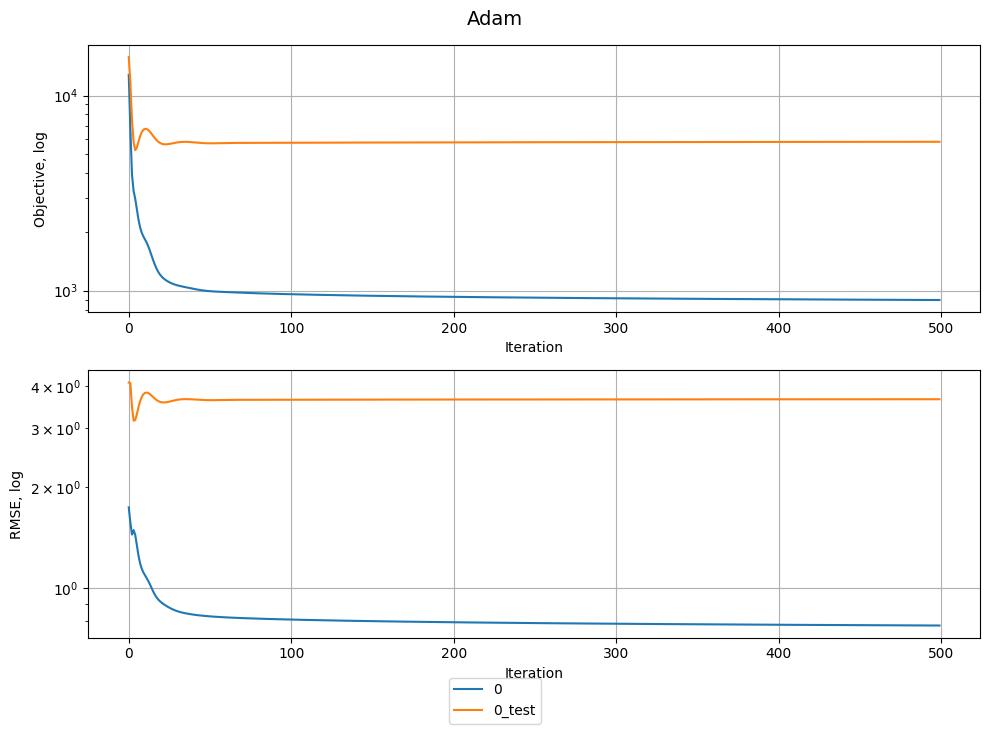

(tensor([[5.0000, 3.4823, 3.3868,  ..., 4.4622, 3.9544, 4.4801],
         [4.3352, 3.3324, 3.3773,  ..., 4.5636, 3.9818, 4.0872],
         [4.0779, 3.1255, 3.6004,  ..., 4.0890, 4.3622, 3.3005],
         ...,
         [3.8376, 2.7349, 3.4034,  ..., 3.3765, 3.7374, 2.4218],
         [3.9036, 2.9043, 2.8508,  ..., 3.8635, 3.9503, 3.7408],
         [3.0000, 1.9666, 1.1238,  ..., 3.1099, 4.8159, 3.5804]],
        device='cuda:0'),
 0.7750696539878845,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Adam,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [138]:
adam_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Adam,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: 1 / (k + 1),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adam_res[-1], "Adam")

adam_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.10it/s, Objective=822, RMSE=0.74]     


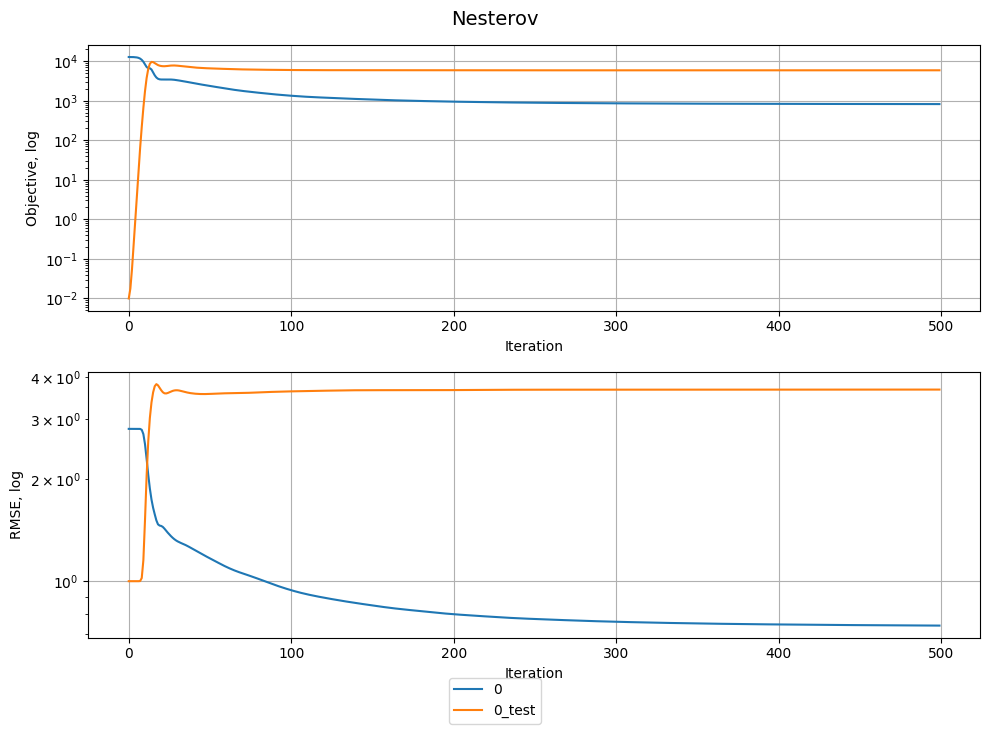

(tensor([[5.0000, 3.2127, 3.1560,  ..., 4.0730, 3.6891, 3.4230],
         [4.5666, 3.2502, 3.7406,  ..., 5.0000, 3.6281, 3.7640],
         [3.5054, 3.0563, 3.9330,  ..., 4.5392, 4.1960, 3.9267],
         ...,
         [3.8870, 3.6306, 3.1158,  ..., 4.3416, 5.0000, 5.0000],
         [3.7149, 3.0422, 2.8310,  ..., 3.5852, 4.3692, 3.9709],
         [3.0000, 1.6427, 1.0000,  ..., 3.0450, 4.6840, 3.8462]],
        device='cuda:0'),
 0.7397009134292603,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Nesterov,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [139]:
nesterov_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Nesterov,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: max(1e-4 / np.sqrt(k + 1), 1e-6),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(nesterov_res[-1], "Nesterov")

nesterov_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 86.91it/s, Objective=861, RMSE=0.757]    


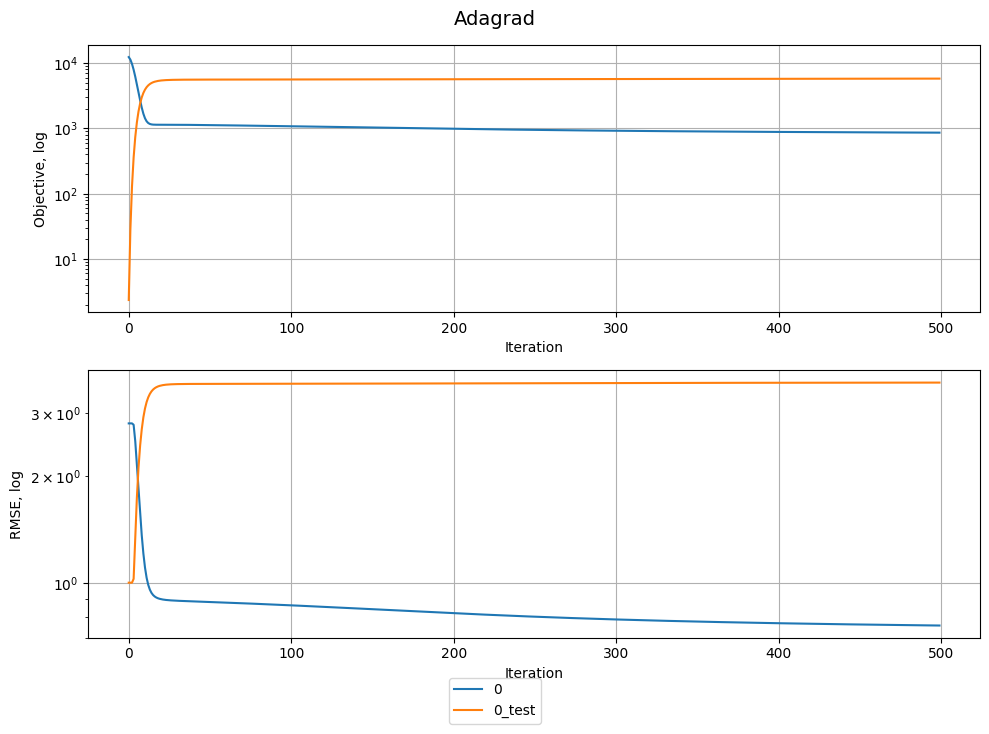

(tensor([[5.0000, 3.6569, 3.4432,  ..., 4.0861, 3.5065, 3.9579],
         [4.2649, 3.5046, 3.2638,  ..., 4.2494, 3.9642, 3.9375],
         [4.1146, 3.5355, 3.7461,  ..., 4.1596, 4.8135, 4.0014],
         ...,
         [3.1801, 2.4239, 2.4107,  ..., 3.5083, 5.0000, 3.7553],
         [3.9549, 3.1263, 2.7542,  ..., 3.7172, 4.5162, 3.9736],
         [3.0000, 2.2475, 1.4865,  ..., 2.8222, 4.7049, 3.5275]],
        device='cuda:0'),
 0.7572656273841858,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.AdaGrad,
  'regularization': 0,
  'clip': False,
  'lr': 0.1,
  'lr_strategy': 'normal'})

In [140]:
adagrad_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": AdaGrad,
        "regularization": 0,
        "clip": False,
        "lr": 1e-1,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adagrad_res[-1], "Adagrad")

adagrad_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.16it/s, Objective=848, RMSE=0.751]    


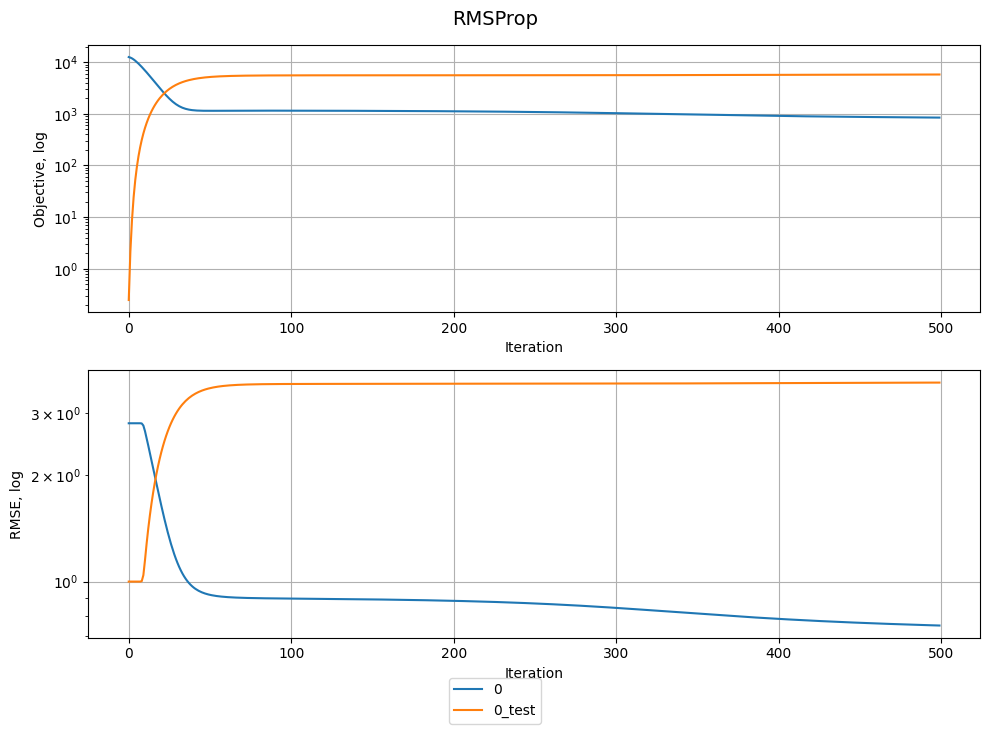

(tensor([[5.0000, 3.4498, 3.2274,  ..., 4.1927, 3.5288, 3.9888],
         [4.2703, 3.4253, 3.2567,  ..., 4.3202, 3.9002, 3.8647],
         [3.9040, 3.5322, 3.7221,  ..., 4.2526, 5.0000, 4.0841],
         ...,
         [3.3296, 2.8649, 2.6476,  ..., 3.5210, 5.0000, 3.9541],
         [3.9038, 3.1277, 2.8111,  ..., 3.6918, 4.5938, 4.0182],
         [3.0000, 2.2566, 1.5161,  ..., 2.6281, 4.6619, 3.5856]],
        device='cuda:0'),
 0.750562310218811,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.RMSprop,
  'regularization': 0,
  'clip': False,
  'lr': 0.005,
  'lr_strategy': 'normal'})

In [141]:
rms_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": RMSprop,
        "regularization": 0,
        "clip": False,
        "lr": 5e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(rms_res[-1], "RMSProp")

rms_res[:-1]

In [255]:
# save_solution(rms_res[0], decimals=5, prefix="rms_")

## Heuristic


In [256]:
# def clamp_to_mean(
#     result: torch.tensor, matrix: torch.tensor, mask: torch.tensor
# ) -> torch.tensor:
#     x = result.clone()

#     means = torch.sum(matrix, axis=0) / torch.sum(mask, axis=0)

#     for j, m in zip(range(x.shape[1]), means):
#         lower = torch.where(x[:, j] > m)[0]
#         upper = torch.where(x[:, j] <= m)[0]
#         x[lower, j] = torch.floor(x[lower, j]).float()
#         x[upper, j] = torch.ceil(x[upper, j]).float()

#     return matrix + (~mask) * x



In [257]:
# mean_res = clamp_to_mean(gd_res[0], real_matrix, real_mask)

In [258]:
# save_solution(mean_res, decimals=0, prefix="gdeur")

In [259]:
# save_solution(torch.round(gd_res[0]), decimals=0, prefix="gderound")